# Market Data Collection: BTC & NIFTY 50

This notebook collects historical daily price data for:
- Bitcoin (BTC-USD)
- NIFTY 50 Index (^NSEI)

The data will be used for downstream sentiment alignment
and correlation analysis.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
def unix_to_datetime(ts):
    return pd.to_datetime(ts, unit="ms")

In [3]:
def fetch_btc_data():
    df = yf.download(
        "BTC-USD",
        start="2016-01-01",
        progress=False
    )
    df = df.reset_index()
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]
    df.columns = ["date", "open", "high", "low", "close", "volume"]
    return df

btc_prices = fetch_btc_data()
btc_prices.head(), btc_prices.tail(), len(btc_prices)

(        date        open        high         low       close    volume
 0 2016-01-01  430.721008  436.246002  427.515015  434.334015  36278900
 1 2016-01-02  434.622009  436.062012  431.869995  433.437988  30096600
 2 2016-01-03  433.578003  433.743011  424.705994  430.010986  39633800
 3 2016-01-04  430.061005  434.516998  429.084015  433.091003  38477500
 4 2016-01-05  433.069000  434.182007  429.675995  431.959991  34522600,
            date          open          high           low         close  \
 3646 2025-12-25  87608.320312  88501.789062  86949.257812  87234.742188   
 3647 2025-12-26  87235.507812  89459.429688  86628.140625  87301.429688   
 3648 2025-12-27  87301.429688  87874.781250  87182.976562  87802.156250   
 3649 2025-12-28  87799.343750  87986.890625  87394.953125  87835.835938   
 3650 2025-12-30  87132.921875  87347.367188  86830.468750  87148.609375   
 
            volume  
 3646  19953216347  
 3647  42455674908  
 3648  13741199310  
 3649  15156557929  
 365

In [4]:
def fetch_nifty_data():
    df = yf.download(
        "^NSEI",
        start="2012-01-01",
        progress=False
    )
    df = df.reset_index()
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]
    df.columns = ["date", "open", "high", "low", "close", "volume"]
    return df

nifty_prices = fetch_nifty_data()
nifty_prices.head(), nifty_prices.tail(), len(nifty_prices)

(        date         open         high          low        close  volume
 0 2012-01-03  4675.799805  4773.100098  4675.799805  4765.299805       0
 1 2012-01-04  4774.950195  4782.850098  4728.850098  4749.649902       0
 2 2012-01-05  4749.000000  4779.799805  4730.149902  4749.950195       0
 3 2012-01-06  4724.149902  4794.899902  4686.850098  4754.100098       0
 4 2012-01-09  4747.549805  4758.700195  4695.450195  4742.799805       0,
            date          open          high           low         close  \
 3430 2025-12-22  26055.849609  26180.699219  26047.800781  26172.400391   
 3431 2025-12-23  26205.199219  26233.550781  26119.050781  26177.150391   
 3432 2025-12-24  26170.650391  26236.400391  26123.000000  26142.099609   
 3433 2025-12-26  26121.250000  26144.199219  26008.599609  26042.300781   
 3434 2025-12-29  26063.349609  26106.800781  25920.300781  25942.099609   
 
       volume  
 3430  253000  
 3431  216600  
 3432  188800  
 3433  142200  
 3434  234300  ,


In [6]:
btc_prices.to_csv("data/raw/btc_prices.csv", index=False)
nifty_prices.to_csv("data/raw/nifty_prices.csv", index=False)
print("Data Expanded Successfully!")

Data Expanded Successfully!


<Axes: title={'center': 'NIFTY 50 Closing Price'}, xlabel='date'>

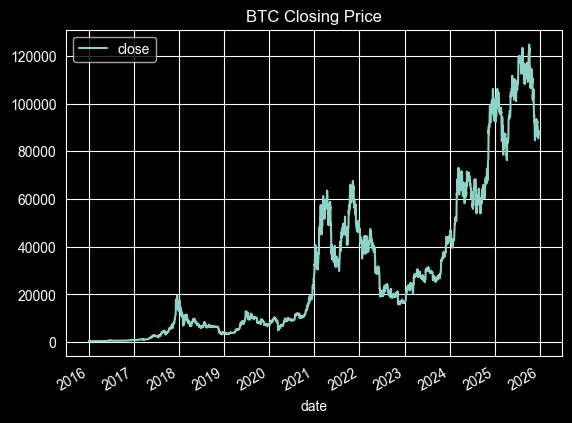

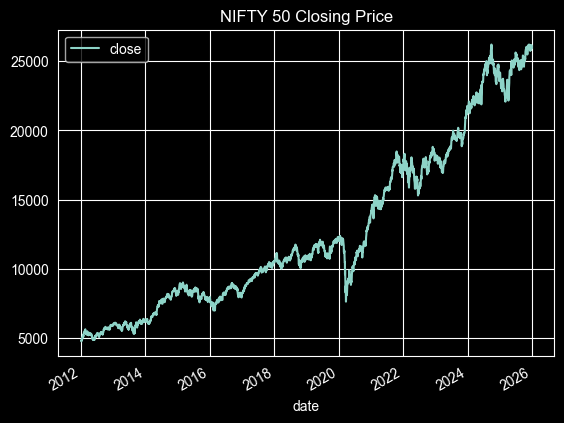

In [8]:
btc_prices.plot(x="date", y="close", title="BTC Closing Price")
nifty_prices.plot(x="date", y="close", title="NIFTY 50 Closing Price")

## Summary

- BTC and NIFTY 50 historical price data collected successfully
- Data stored in `/data/raw/`
- No preprocessing or transformations applied at this stage
- Next step: Text data collection and preprocessing